In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import newton

In [28]:
def f(ex):
    return 100 * (ex[1] - ex[0] ** 2) ** 2 + (1 - ex[0]) ** 2

def get_grad(func, ex, dh=1e-8):
    """
    This function computes the numerical gradient of a function of
    multiple variables using a difference quotient schema.
    :param func:
    :param ex:
    :param dh:
    :return:
    """
    x_mat = np.repeat([ex], repeats=ex.size, axis=0)
    off = dh * np.eye(ex.size)
    x_minus = x_mat - off
    x_plus = x_mat + off
    backward_diff = np.fromiter(map(func, x_minus), dtype=ex.dtype)
    forward_diff = np.fromiter(map(func, x_plus), dtype=ex.dtype)
    return (forward_diff - backward_diff) / (2 * dh)

def hermite_cubic(a_prev, a_curr, func, dfunc):
    a_diff = a_curr - a_prev
    return lambda alpha: (1 + (alpha - a_prev) / a_diff) * ((a_curr - alpha) / a_diff) ** 2 * func(a_prev) + \
                         (1 + 2 * (a_curr - alpha) / a_diff) * ((alpha - a_prev) / a_diff) ** 2 \
                         * func(a_curr) + (alpha - a_prev) * ((a_curr - alpha) / a_diff) ** 2 * \
                         dfunc(a_prev) + (alpha - a_curr) * ((alpha - a_prev) / a_diff) ** 2 * \
                         dfunc(a_curr)


def hermite_min(a_prev, a_curr, func, d_func):
    phi_prev, phi_curr = func(a_prev), func(a_curr)
    phi_p_prev, phi_p_curr = d_func(a_prev), d_func(a_curr)
    d_1 = phi_p_prev + phi_p_curr - 3*(phi_prev- phi_curr)/(a_prev-a_curr)
    d_2 = np.sign(a_curr - a_prev)*np.sqrt(d_1**2 - phi_p_prev*phi_p_curr)
    return a_curr - (a_curr - a_prev)*(phi_p_curr + d_2 - d_1)/\
           (phi_p_curr - phi_p_prev + 2*d_2)


def phi_maker(ex, pea):
    return lambda alpha: f(ex + alpha * pea)

def prime_maker(func, delta=1e-8):
    return lambda alpha: (func(alpha + delta) - func(alpha - delta)) / (2 * delta)


def one_d_newton(x_low, x_high, func, d_func, tolerance=1e-8):
    x = (x_low + x_high) / 2
    while np.abs(func(x)) > tolerance and x_low < x < x_high:
        x -= func(x) / d_func(x)
    return x


def QC_interpolate(a_low, a_high, c_1, func, dfunc, tolerance=1e-6):
    phi_high = func(a_high)
    phi_low = func(a_low)
    phi_p_low = dfunc(a_low)
    if phi_high - phi_low - a_high * phi_p_low < tolerance:
        a_new = -.5 * ((a_high ** 2) * phi_p_low) / tolerance
    else:
        a_new = -.5 * ((a_high ** 2) * phi_p_low) / (phi_high - phi_low - a_high * phi_p_low)
    phi_a_new = func(a_new)
    if phi_a_new <= phi_low + c_1 * a_new * phi_p_low:
        return a_new
    while True:
        # print("Right here, Chief.")
        phi_high = func(a_high)
        a_b = np.array([[a_high ** 2, -a_new ** 2], [-a_high ** 3, a_new ** 3]]) @ \
              np.array([phi_a_new - phi_low - a_new * phi_p_low, phi_high - phi_low - a_high * phi_p_low]) / \
              ((a_high * a_new) ** 2 * (a_high - a_low))
        a_high = a_new
        a_new = (-a_b[1] + np.sqrt(a_b[1] ** 2 - 3 * a_b[0] * phi_p_low)) / (3 * a_b[0])
        phi_a_new = func(a_new)
        if phi_a_new <= phi_low + c_1 * a_new * phi_p_low:
            return a_new
        elif np.abs(a_high - a_new) < tolerance or np.abs(a_new) < tolerance:
            a_new /= 2


def double_prime_maker(func, delta=1e-8):
    return lambda t: (func(t) - 2*func(t - delta) + func(t - 2*delta))/delta**2


def bisection(a_low, a_high, func, tolerance=1e-8):
    while np.abs(a_high - a_low) > tolerance:
        m = .5 * (a_low + a_high)
        if np.sign(func(m)) != np.sign(func(a_high)):
            a_low = m
        else:
            a_high = m
    return .5 * (a_low + a_high)


def hermite_interpolate(a_low, a_high, func, dfunc, c_1=1e-4, c_2=.9):
    if np.abs(a_low - a_high) < 1e-8:
        return a_high
    interpol = hermite_cubic(a_low, a_high, func, dfunc)
    a_new = bisection(a_low, a_high, prime_maker(interpol))
    if a_low <= a_new <= a_high:
        print("Chillin'.")
    else:
        print("Not chillin'...")
    if np.abs(dfunc(a_new)) <= -c_2 * dfunc(0):
        return a_new
    if func(a_new) > func(0) + c_1 * a_new * dfunc(0) or (func(a_new) >= func(a_low)):
        return hermite_interpolate(a_low, a_new, func, dfunc)
    else:
        return hermite_interpolate(a_new, a_high, func, dfunc)


def bisection(a_low, a_high, func, tolerance=1e-8):
    """
    A simple bisection method to numerically find the root
    of a function in a given interval.
    :param a_low:
    Left most endpoint of interval.
    :param a_high:
    Right most endpoint of interval.
    :param func:
    The function whose root we want to find.
    :param tolerance:
    The length of the shortest interval we want to consider.
    :return:
    An approximation of the root in [a_low, a_high].
    """
    while np.abs(a_high - a_low) > tolerance:
        m = .5 * (a_low + a_high)
        if np.sign(func(m)) != np.sign(func(a_high)):
            a_low = m
        else:
            a_high = m
    return .5 * (a_low + a_high)


def hermite_cubic(a_prev, a_curr, func, d_func):

    a_diff = a_curr - a_prev if a_curr - a_prev > 1e-8 else 1e-8
    return lambda alpha: (1 + (alpha - a_prev) / a_diff) * ((a_curr - alpha) / a_diff) ** 2 * func(a_prev) + \
                         (1 + 2 * (a_curr - alpha) / a_diff) * ((alpha - a_prev) / a_diff) ** 2 \
                         * func(a_curr) + (alpha - a_prev) * ((a_curr - alpha) / a_diff) ** 2 * \
                         d_func(a_prev) + (alpha - a_curr) * ((alpha - a_prev) / a_diff) ** 2 * \
                         d_func(a_curr)


0.0003122701257348508 0.0009098106579047689
Hermite_min: 169.9179728476366 at -0.0007723349234481033,
Bisection_min: 11.815737842557786 at 0.00031227468460731916


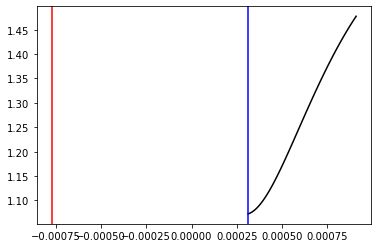

In [50]:
bounds = np.random.uniform(0,1e-3, size=(2, 1))
a_low = bounds.min()
a_high = bounds.max()
print(a_low, a_high)
x = np.array([1.2,1.2])
p = get_grad(f, x)

a_func = phi_maker(x, p)
a_func_prime = prime_maker(a_func)

interpol = hermite_cubic(a_low, a_high, a_func, a_func_prime)
a_hermite = hermite_min(a_low, a_high, a_func, a_func_prime)
inter_prime = prime_maker(interpol)
#inter_double_prime = double_prime_maker(interpol)

As = np.linspace(a_low, a_high, 101)

plt.plot(As, np.log10(interpol(As)), '-k')
#plt.plot(As, inter_prime(As), '-b')
#a_min = newton(inter_prime, (a_low+a_high)*.5)
a_min = bisection(a_low, a_high, inter_prime)
plt.axvline(x=a_min, color='blue')
plt.axvline(x=a_hermite, color='red')
print(f"Hermite_min: {interpol(a_hermite)} at {a_hermite},\n"
      f"Bisection_min: {interpol(a_min)} at {a_min}")

In [30]:
np.abs(a_hermite - a_min)

nan